
#Exam Deep Learning - Blind Source Separation
Student: DEANA ALESSIA \

The purpose of the project is to separate an image obtained as a sum of a two images into its components.

The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.

No preprocessing is allowed. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2.

The metric used to evaluate the project is the mean squared error between predicted and ground truth images. \


ARCHITECTURE CHOOSEN: **U-NET**

In [ ]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
print(np.__version__)

import matplotlib
from matplotlib import pyplot as plt
print(matplotlib.__version__)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist

import numpy as np
from matplotlib import pyplot as plt

2.8.2
1.21.6
3.2.2


In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
4431872/4422102 [==============================] - 0s 0us/step
(60000, 32, 32)


In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data

In [ ]:
print(fashion_mnist_x_train.shape)
print(mnist_x_train.shape)

(60000, 32, 32)
(60000, 32, 32)


In [ ]:
batchsize = 64
inputShape = (32,32,1)

In [ ]:
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,batchsize)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,batchsize)

In [ ]:
x_train, y_train = next(train_generator)
x_test, y_test = next(test_generator)


print("x, y train shape")
print(x_train.shape, y_train.shape)
print("x, y test shape")
print(x_test.shape, y_test.shape)

x, y train shape
(64, 32, 32) (64, 32, 64)
x, y test shape
(64, 32, 32) (64, 32, 64)


#Build The Architecture of U-Net Network

U-Net is good with segmentation tasks because it can localize well to provide high resolution segmentation masks. \
We build a *Semi-Siamese U-net*, built with an encoder portion and two decoder.
The encoder portion is composed of a linear stack of Conv, BatchNorm, and Relu operations followed by a MaxPool. Each MaxPool will reduce the spatial resolution of our feature map by a factor of 2. \
We keep track of the outputs of each block as we feed these high resolution feature maps with the decoder portion. The Decoder portion is comprised of UpSampling2D, Conv, BatchNorm, and Relus.

##The Keras Functional API
The Keras functional API is used when you have multi-input/output models, shared layers, etc. It's a powerful API that allows you to manipulate tensors and build complex graphs with intertwined datastreams easily. In addition it makes layers and models both callable on tensors.

*References*:
* Keras guide: [guide](https://keras.io/getting-started/functional-api-guide/)
* U-NET architecture: [u-net](https://colab.research.google.com/github/MarkDaoust/models/blob/segmentation_blogpost/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb#scrollTo=7Plun_k1dAML)
* Semi-siamese U-net: [semi-siamese](https://journals.plos.org/plosone/article/figure?id=10.1371/journal.pone.0246071.g001)


Here you can find the idea of Architecture of the Semi-siamese U-net:

<div>

<img src="https://journals.plos.org/plosone/article/figure/image?size=large&id=10.1371/journal.pone.0246071.g001" width="600"/>

</div>






In [ ]:
import tensorflow as tf

from tensorflow import keras as ks
from tensorflow.keras import models
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import Sequential

def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)

  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [ ]:
def build_unet():
  inputs = layers.Input(shape=(32,32,1))

  #encoder
  encoder0_pool, encoder0 = encoder_block(inputs, 32)

  encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)

  encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)

  encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)

  encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)

  a_center = conv_block(encoder4_pool, 1024)
  b_center = conv_block(encoder4_pool, 1024)

  #decoder
  a_decoder4 = decoder_block(a_center, encoder4, 512)
  b_decoder4 = decoder_block(b_center, encoder4, 512)

  a_decoder3 = decoder_block(a_decoder4, encoder3, 256)
  b_decoder3 = decoder_block(b_decoder4, encoder3, 256)

  a_decoder2 = decoder_block(a_decoder3, encoder2, 128)
  b_decoder2 = decoder_block(b_decoder3, encoder2, 128)

  a_decoder1 = decoder_block(a_decoder2, encoder1, 64)
  b_decoder1 = decoder_block(b_decoder2, encoder1, 64)

  a_decoder0 = decoder_block(a_decoder1, encoder0, 32)
  b_decoder0 = decoder_block(b_decoder1, encoder0, 32)

  output1 = layers.Conv2D(1, (1, 1), activation='sigmoid')(a_decoder0)
  output2 = layers.Conv2D(1, (1, 1), activation='sigmoid')(b_decoder0)
  outputs = tf.concat([output1, output2], axis = 2)
  model = models.Model(inputs=[inputs], outputs=[outputs])
  model.summary()

  return model

In [ ]:
model = build_unet()
model.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-4),
                  loss = tf.keras.losses.MeanSquaredError(),
                  metrics=['mse'])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

#Plot of The Model

Plot the model of the U-Net

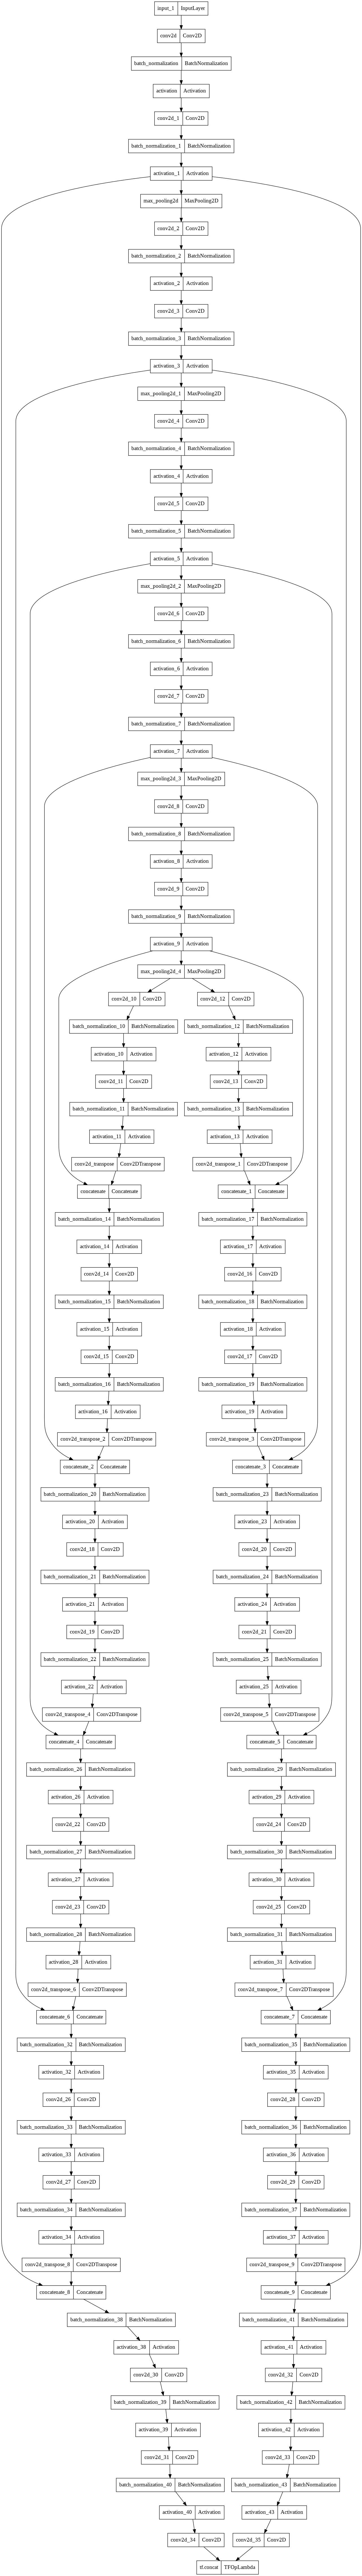

In [ ]:
tf.keras.utils.plot_model(model)

#Traning The Model
Training the model with `tf.data` involves  providing the model's `fit` function with your training/validation dataset, the number of steps, and epochs.  

In [ ]:
#Training
BATCH_SIZE = 64
N_EPOCHS = 20

size = mnist_x_train.shape[0]//10 #10% of the train set
indices = np.arange(len(mnist_x_train))
np.random.shuffle(indices)
v_indices = indices[:size]
t_indices = indices[size:]

#validation set
mnist_x_val = mnist_x_train[v_indices]
fashion_mnist_x_val = fashion_mnist_x_train[v_indices]
val_set = datagenerator(mnist_x_val, fashion_mnist_x_val, BATCH_SIZE)
print("shape mnist_x_val:", mnist_x_val.shape)

#train set
fashion_mnist_x_train = fashion_mnist_x_train[t_indices]
mnist_x_train = mnist_x_train[t_indices]
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train, BATCH_SIZE)
print("shape mnist_x_train:",mnist_x_train.shape)



shape mnist_x_val: (6000, 32, 32)
shape mnist_x_train: (54000, 32, 32)


In [ ]:
#fit model

history = model.fit(train_generator,
              batch_size=64,
              epochs=50,
              steps_per_epoch = 4500,
              validation_steps = 20,
              validation_data=val_set)


Epoch 1/50
4500/4500 [==============================] - 373s 80ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/50
4500/4500 [==============================] - 356s 79ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 3/50
4500/4500 [==============================] - 355s 79ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 4/50
4500/4500 [==============================] - 355s 79ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 5/50
4500/4500 [==============================] - 355s 79ms/step - loss: 9.9878e-04 - mse: 9.9878e-04 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 6/50
4500/4500 [==============================] - 355s 79ms/step - loss: 8.9040e-04 - mse: 8.9040e-04 - val_loss: 8.4308e-04 - val_mse: 8.4308e-04
Epoch 7/50
4500/4500 [==============================] - 355s 79ms/step - loss: 8.2205e-04 - mse: 8.2205e-04 - val_loss: 7.7842e-04 - val_mse: 7.7842e-04
E

##Save Weights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.save_weights('/content/drive/MyDrive/ColabNotebooks/Exam_Final_Deana_Alessia.h5')

Mounted at /content/drive


##Visualize Traning Process


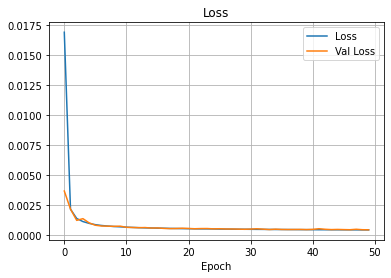

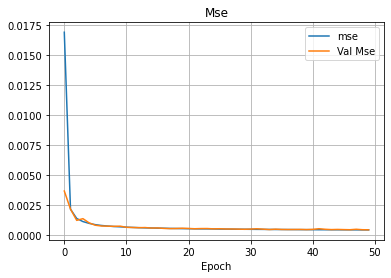

In [ ]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

acc_history = history.history['mse']
val_acc_history = history.history['val_mse']

plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')
plt.show()

plt.plot(acc_history)
plt.plot(val_acc_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['mse', 'Val Mse'])
plt.title('Mse')
plt.show()

#Evaluate The Model

Evaluate the mse over 20000 samples randomly generated from the two test_sets.\
Repeat the computation 10 times and check the standard deviation, that should be very small.

In [ ]:
mse_array=[]

size = 128 #256
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test, size)
for elem in range(10): #valute n.10 the performance

  # randomset of 20000
  evaluate_list = model.evaluate(test_generator,steps=20000//size, verbose=1)
  mse_array.append(evaluate_list[0])

unet_mean = np.mean(mse_array)
unet_std = np.std(mse_array)

156/156 [==============================] - 7s 42ms/step - loss: 4.6405e-04 - mse: 4.6405e-04


In [ ]:
print(unet_mean)
print(unet_std)

0.0004655411292333156
2.249780285595085e-06


#Image Segmentation Outputs

PREDICTION IMAGE


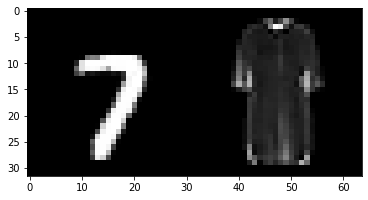

ORIGINAL IMAGE


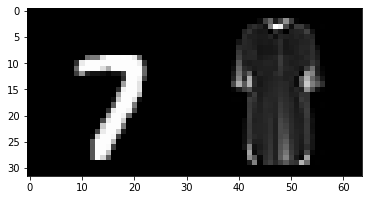

In [ ]:
x, y = next(test_generator)

y_pred = model.predict(x[:1])
print("PREDICTION IMAGE")
plt.imshow(y_pred[0, :, :, 0], cmap='gray', interpolation='nearest')
plt.show()
print("ORIGINAL IMAGE")
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

#Traning the model again

We try to train the model with another fit and the weights that we saved.

In [ ]:
model.load_weights('/content/drive/MyDrive/ColabNotebooks/Exam_Final_Deana_Alessia.h5') #load weights



Fit again the model with a lower number of epochs (in this case with 5 epochs but #if we want a better result we can increase the number of epoches, for examample 20).

In [ ]:
#second fit
history2 = model.fit(train_generator,
              batch_size=64,
              epochs=5,
              steps_per_epoch = 2000,
              validation_steps = 20,
              validation_data=val_set)

Epoch 1/5
2000/2000 [==============================] - 162s 81ms/step - loss: 4.5327e-04 - mse: 4.5327e-04 - val_loss: 4.4775e-04 - val_mse: 4.4775e-04
Epoch 2/5
2000/2000 [==============================] - 162s 81ms/step - loss: 4.5620e-04 - mse: 4.5620e-04 - val_loss: 4.4665e-04 - val_mse: 4.4665e-04
Epoch 3/5
2000/2000 [==============================] - 161s 81ms/step - loss: 4.5315e-04 - mse: 4.5315e-04 - val_loss: 4.7766e-04 - val_mse: 4.7766e-04
Epoch 4/5
2000/2000 [==============================] - 166s 83ms/step - loss: 4.4892e-04 - mse: 4.4892e-04 - val_loss: 4.5963e-04 - val_mse: 4.5963e-04
Epoch 5/5
2000/2000 [==============================] - 161s 80ms/step - loss: 4.5017e-04 - mse: 4.5017e-04 - val_loss: 4.6142e-04 - val_mse: 4.6142e-04


evaluate the model again.

In [ ]:

mse_array2=[]

size = 128 #256
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test, size)
for elem in range(10): #valute n.10 performance

  # randomset of 20000
  evaluate_list2 = model.evaluate(test_generator,steps=20000//size, verbose=1)
  mse_array2.append(evaluate_list2[0])

unet_mean2 = np.mean(mse_array2)
unet_std2 = np.std(mse_array2)

156/156 [==============================] - 7s 42ms/step - loss: 4.6729e-04 - mse: 4.6729e-04


In [ ]:
print(unet_mean2)
print(unet_std2)

0.0004640113707864657
2.074414973160435e-06


Show again the output of the model after the second fit with weights.

PREDICTION IMAGE


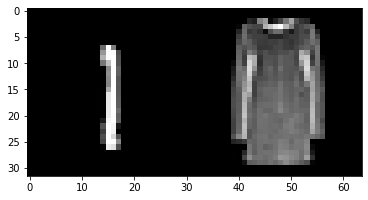

ORIGINAL IMAGE


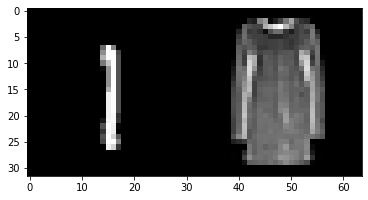

In [ ]:
x, y = next(test_generator)

y_pred = model.predict(x[:1])
print("PREDICTION IMAGE")
plt.imshow(y_pred[0, :, :, 0], cmap='gray', interpolation='nearest')
plt.show()
print("ORIGINAL IMAGE")
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

#RESULT AND CONCLUSION



*Here are the result of the Semi-siamese U-Net Model with the first fit.*



> **mse mean:** 0.0004655411292333156 \


> **standard deviation:** 2.249780285595085e-06
